In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import scipy.interpolate
from matplotlib.tri import Triangulation

from pymoo.performance_indicator.hv import Hypervolume
from pymoo.visualization.petal import Petal
from pymoo.visualization.star_coordinate import StarCoordinate
from matplotlib.markers import MarkerStyle

In [2]:
preference_to_solution_mapping = pd.read_csv("preference_direction_to_solution_mapping.csv")
preference_to_solution_mapping

,Unnamed: 0,Ref_dir [1 0 1],User_pref,Ref_dir [1 0 0],Ref_dir [1 1 0],Ref_dir [0 1 0],Ref_dir [0 1 1],Ref_dir [0 0 1]
0,0,0.078980,0.078704,0.078704,0.059016,0.059016,0.054413,0.058932
1,1,0.265052,0.274390,0.274390,0.547884,0.547884,0.630595,0.576540
2,2,0.074783,0.070646,0.070646,0.039088,0.039088,0.315545,0.374208


In [3]:
## do it manually...
preference_to_solution_mapping = [
    (np.array([1,0,1]), preference_to_solution_mapping.iloc[:,1].T.values),
    (np.array([0,0.5,0.5]), preference_to_solution_mapping.iloc[:,2].T.values),
    (np.array([1,0,0]), preference_to_solution_mapping.iloc[:,3].T.values),
    (np.array([1,1,0]), preference_to_solution_mapping.iloc[:,4].T.values),
    (np.array([0,1,0]), preference_to_solution_mapping.iloc[:,5].T.values),
    (np.array([0,1,1]), preference_to_solution_mapping.iloc[:,6].T.values),
    (np.array([0,0,1]), preference_to_solution_mapping.iloc[:,7].T.values),
]
preference_to_solution_mapping

[(array([1, 0, 1]), array([0.0789799 , 0.26505235, 0.07478289])),
 (array([0. , 0.5, 0.5]), array([0.07870425, 0.27438986, 0.07064606])),
 (array([1, 0, 0]), array([0.07870425, 0.27438986, 0.07064606])),
 (array([1, 1, 0]), array([0.05901565, 0.5478845 , 0.03908817])),
 (array([0, 1, 0]), array([0.05901565, 0.5478845 , 0.03908817])),
 (array([0, 1, 1]), array([0.05441302, 0.63059546, 0.31554546])),
 (array([0, 0, 1]), array([0.05893212, 0.57653993, 0.37420802]))]

In [5]:
#full_pareto_front = np.load("full_pareto_front.npy", allow_pickle=True, fix_imports=True)

## CONTAINS DUPLICATES
full_pareto_front = np.unique(pd.read_csv("Pareto_front.csv").iloc[:,1:].T.values, axis=0)
#full_pareto_front = np.array(list(full_pareto_front[0].values()))

(123, 3)


<Figure size 432x288 with 0 Axes>

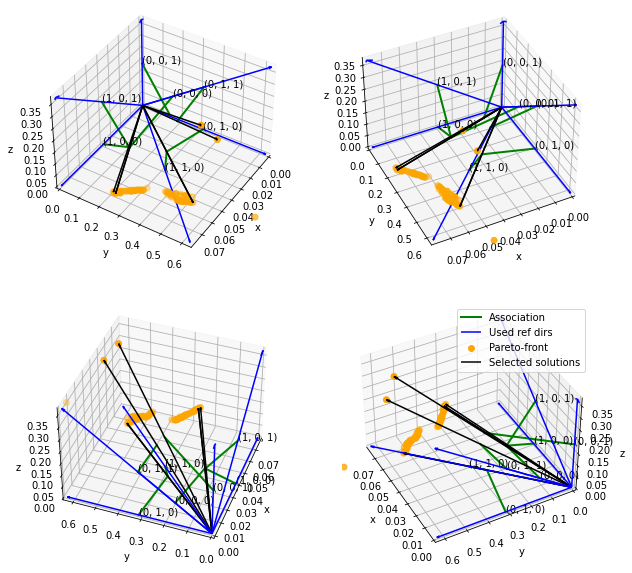

In [5]:
def plot_pareto_front(associations, all_preference_vectors=None, full_pareto_front=None):
    #plt.clf()
        
    fig = plt.figure(figsize=(10,10))
    #fig.subplots_adjust(hspace=0.0, wspace=0.0)
    for i, angle in enumerate([32, 64, 200, 152]):
        ax = fig.add_subplot(2,2,i+1, projection='3d')
        
        # TODO maybe adjust elevation?
        ax.view_init(elev=40., azim=angle)

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        
        final_selected_solutions = np.row_stack([r[1] for r in associations])

        used_ref_dirs = np.row_stack([r[0] for r in associations])
        unused_ref_dirs = []
        for row in all_preference_vectors:
            isin = False
            for used_row in used_ref_dirs:
                if np.array_equal(row, used_row):
                    isin = True
            if not isin:    
                unused_ref_dirs.append(row)
        if len(unused_ref_dirs) > 0:
            unused_ref_dirs = np.row_stack(unused_ref_dirs).T
        used_ref_dirs = used_ref_dirs.T

        # if we use final_selected_solutions for the max instead of
        # pareto_front, then we focus on the selected solutions, but
        # some of the complete pareto_front are not shown in the plot!
        # I think it makes sense this way though
        scale_factor_x = 1.0 / max(final_selected_solutions[:,0])
        scale_factor_y = 1.0 / max(final_selected_solutions[:,1])
        scale_factor_z = 1.0 / max(final_selected_solutions[:,2])

        #scale_factor_x, scale_factor_y, scale_factor_z = (1.0,1.0,1.0)

        orig_used_ref_dirs = used_ref_dirs.copy().T

        used_ref_dirs[0,:] /= scale_factor_x
        used_ref_dirs[1,:] /= scale_factor_y
        used_ref_dirs[2,:] /= scale_factor_z

        if len(unused_ref_dirs) > 0:
            unused_ref_dirs[0,:] /= scale_factor_x
            unused_ref_dirs[1,:] /= scale_factor_y
            unused_ref_dirs[2,:] /= scale_factor_z

        ax.set_xlim(0,1/scale_factor_x)
        ax.set_ylim(0,1/scale_factor_y)
        ax.set_zlim(0,1/scale_factor_z)

        ratio = 0.02

        #print(used_ref_dirs)
        #print(unused_ref_dirs)

        x, y, z = np.zeros((3,used_ref_dirs.shape[1]))
        u, v, w = used_ref_dirs
        ax.quiver(x,y,z,u,v,w,arrow_length_ratio=ratio,
                  color="blue", label="Used ref dirs", zorder=0)

        if len(unused_ref_dirs) > 0:
            x, y, z = np.zeros((3,unused_ref_dirs.shape[1]))
            u, v, w = unused_ref_dirs
            ax.quiver(x,y,z,u,v,w,arrow_length_ratio=ratio,
                      color="red", label="Unused ref dirs", zorder=0)

        for i,row in enumerate(orig_used_ref_dirs):
            x,y,z = row
            label = '(%d, %d, %d)' % (x, y, z)
            xx, yy, zz = used_ref_dirs.T[i,:] / 2
            ax.text(xx, yy, zz, label)

        ax.scatter(xs=full_pareto_front[:,0],ys=full_pareto_front[:,1],zs=full_pareto_front[:,2],label="Pareto-front",
                   color="orange", s=35, zorder=1)

        #x,y,z = full_pareto_front.T
        #triang = Triangulation(x,y)
        #ax.plot_trisurf(triang, z, color='green', shade=True, alpha=0.5)

        """
        x_grid = np.linspace(0, max(final_selected_solutions[:,0]), 1*len(x))
        y_grid = np.linspace(0, max(final_selected_solutions[:,1]), 1*len(y))
        X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')
        spline = sp.interpolate.Rbf(x,y,z,function='thin_plate',smooth=0.1)#, episilon=5)
        Z = spline(X,Y)
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                        cmap='winter', edgecolor='none')
        """
        """
        x_grid = np.linspace(0, max(final_selected_solutions[:,0]), 1*len(x))
        y_grid = np.linspace(0, max(final_selected_solutions[:,1]), 1*len(y))
        B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
        Z = np.zeros((x.size, z.size))
        spline = sp.interpolate.Rbf(x,y,z,function='thin_plate',smooth=0.1)#, episilon=5)
        Z = spline(B1,B2)
        ax.plot_wireframe(B1, B2, Z, zorder=1)
        ax.plot_surface(B1, B2, Z,alpha=0.2,zorder=1)
        """

        #print(final_selected_solutions)
        final_selected_solutions = final_selected_solutions.T
        #ax.scatter(xs=final_selected_solutions[:,0],ys=final_selected_solutions[:,1],zs=final_selected_solutions[:,2],label="Pareto-front",
        #           color="k", s=35)
        x, y, z = np.zeros((3,final_selected_solutions.shape[1]))
        u, v, w = final_selected_solutions
        ax.quiver(x,y,z,u,v,w,arrow_length_ratio=ratio,
                  color="black", label="Selected solutions", zorder=2)

        for i, row in enumerate(final_selected_solutions.T):
            associated_vector = used_ref_dirs.T[i,:]
            x,y,z = row / 2
            xx,yy,zz = associated_vector / 2
            ax.plot([x,xx],[y,yy],[z,zz],color="green",linewidth=2, label="Association" if i==0 else None, zorder=2)
        #ax.grid(False)
        
    plt.legend(loc="best")
    #plt.tight_layout()
    plt.savefig("pareto_front_with_ref_dirs.pdf", bbox_inches="tight")
    plt.show()
    
print(full_pareto_front.shape)

preference = [x[0] for x in preference_to_solution_mapping]
plot_pareto_front(preference_to_solution_mapping, np.array(preference), full_pareto_front)

[[0.0789799  0.26505235 0.07478289]
 [0.07870425 0.27438986 0.07064606]
 [0.07870425 0.27438986 0.07064606]
 [0.05901565 0.5478845  0.03908817]
 [0.05901565 0.5478845  0.03908817]
 [0.05441302 0.63059546 0.31554546]
 [0.05893212 0.57653993 0.37420802]]
[[0.0789799  0.26505235 0.07478289]
 [0.07870425 0.27438986 0.07064606]
 [0.07870425 0.27438986 0.07064606]
 [0.05901565 0.5478845  0.03908817]
 [0.05901565 0.5478845  0.03908817]
 [0.05441302 0.63059546 0.31554546]
 [0.05893212 0.57653993 0.37420802]
 [       nan        nan        nan]]


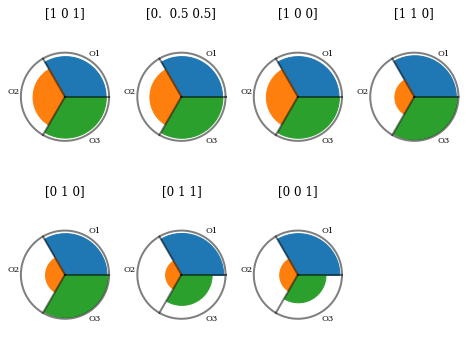

In [35]:
from pymoo.visualization.petal import Petal

F = np.array([x[1] for x in preference_to_solution_mapping])
print(F)
F = np.row_stack([F,[np.nan,np.nan,np.nan]])
print(F)
#F = 1.0 - F # for better visualization invert the fitness
# now higher value is better
plot = Petal(bounds=[0, 1], 
             title=["%s" % r for r in [x[0] for x in preference_to_solution_mapping]+[""]],
             #cmap="tab20",
             labels=["O1", "O2", "O3"], # TODO
             reverse=True,
             #tight_layout=True,
             #figsize=(4,4)
            )
#plot.add(F)
plot.add(F[:4])
plot.add(F[4:])
plot.show()
#print(plot.get_plot())
plot.ax.flatten()[-1].remove()
plt.savefig("objectives_per_solution.pdf", bbox_inches="tight")

[[1.  0.  1. ]
 [0.  0.5 0.5]
 [1.  0.  0. ]
 [1.  1.  0. ]
 [0.  1.  0. ]
 [0.  1.  1. ]
 [0.  0.  1. ]]


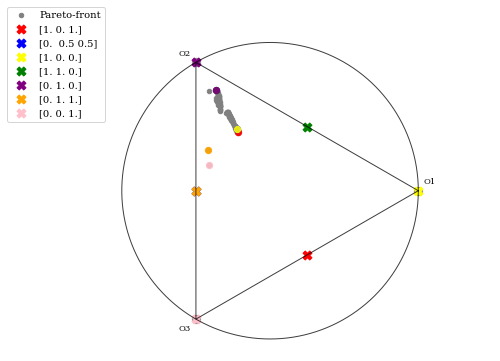

In [37]:
from pymoo.visualization.star_coordinate import StarCoordinate
from pymoo.visualization.radviz import Radviz
from matplotlib.markers import MarkerStyle

F = np.array([x[1] for x in preference_to_solution_mapping])
refs = np.array([x[0] for x in preference_to_solution_mapping])
print(refs)
all_F = full_pareto_front

plot = Radviz(#title="Optimization",
                      legend=(True, {'loc': "upper left", 'bbox_to_anchor': (-0.1, 1.08, 0, 0)}),
                      labels=["O1", "O2", "O3"],
                      #axis_style={"color": "blue", 'alpha': 0.7},
                      arrow_style={"head_length": 0.015, "head_width": 0.03})
plot.add(all_F, color="grey", s=20, label="Pareto-front")
# colors are not ideal yet TODO
colors = ["red", "blue", "yellow", "green", "purple", "orange", "pink"]
markers = ["o", "v", "*", "s", "d", "P", "x"]
for f,c,r in zip(F, colors, refs):
    lab = f"[{r[0]}, {r[1]}, {r[2]}]"
    plot.add(r, color=c, s=80, marker="X", label=r)#, label=lab)
for f,c,m in zip(F, colors, refs):
    plot.add(f, s=40, alpha=0.9, color=c) # not sure how to get the markers to work here
#plot.add(F[65], color="red", s=70, label="Solution A")
#plot.add(F[72], color="green", s=70, label="Solution B")

plot.show()
plt.savefig("pareto_front.pdf", bbox_inches="tight")

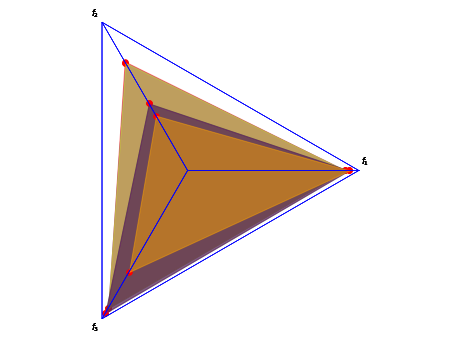

In [44]:
#from pymoo.visualization.radar import Radar

F = np.array([x[1] for x in preference_to_solution_mapping])
refs =  np.array([x[0] for x in preference_to_solution_mapping])
#F = 1.0 - F # for better visualization invert the fitness
# ^ done by reverse=True

plot = Radar(bounds=[0, 1],
             axis_style={"color": 'blue'},
             point_style={"color": 'red', 's': 30},
             cmap="tab20",
             #title = ["Solution %s" % t for t in range(len(F))],
             normalize_each_objective=True,
             reverse=True
             #n_partitions=20,
            )

colors = ["red", "blue", "yellow", "green", "purple", "orange"]
for f,c,r in zip(F, colors, refs):
    plot.add(f, color=c, alpha=0.5, label=r)
plot.show()

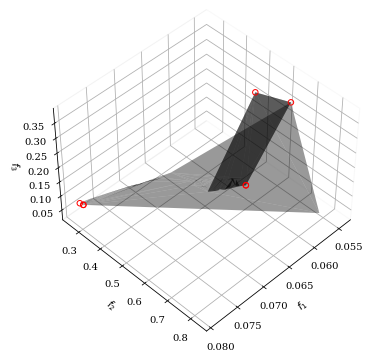

In [13]:
from pymoo.visualization.scatter import Scatter
plot = Scatter()
F = np.array([x[1] for x in preference_to_solution_mapping])
refs =  np.array([x[0] for x in preference_to_solution_mapping])
plot.add(full_pareto_front, plot_type="line", color="black", alpha=0.4, linewidth=1)
plot.add(F, s=30, facecolors='none', edgecolors='r')
plot.show()

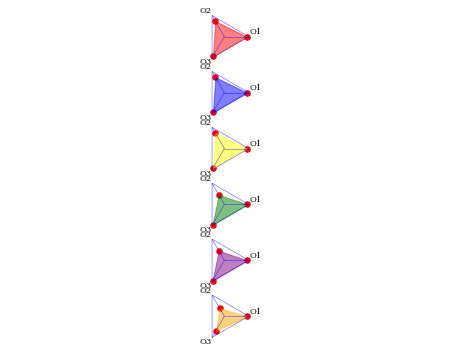

In [36]:
from pymoo.visualization.radar import Radar

F = np.array([x[1] for x in preference_to_solution_mapping])
refs =  np.array([x[0] for x in preference_to_solution_mapping])
#F = 1.0 - F # for better visualization invert the fitness
# ^ done by reverse=True

plot = Radar(bounds=[0, 1],
             axis_style={"color": 'blue'},
             point_style={"color": 'red', 's': 30},
             cmap="tab20",
             #title = ["Solution %s" % t for t in range(len(F))],
             normalize_each_objective=True,
             reverse=True,
             #n_partitions=10,
             labels=["O1", "O2", "O3"],
             #legend=True
            )

colors = ["red", "blue", "yellow", "green", "purple", "orange"]
#plot.add(F)
#plot.add(F[:3,:])
#plot.add(F[3:,:])
for f,c,r in zip(F, colors, refs):
    plot.add(f.reshape(1,-1), color=c, alpha=0.5)
plot.show()